# Input Analysis

This notebook contains our analysis of the input data sets to understand the basic demographic distribution before we run experiments.

## Setup

First, we want to load some libraries.

In [4]:
library(dplyr)
library(readr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
options(repr.plot.height=5)
options(repr.matrix.max.rows=10)
options(repr.matrix.max.columns=10)

We also want need a utility function that will render a plot to files, in addition to rendering it to the notebook.

In [6]:
source("plot-tools.R")

We need to be able to normalize ages.

In [20]:
ml_age_bins = c("1"="1-17", "18"="18-24", "25"="25-34", "35"="35-44", "45"="45-49", "50"="50-55", "56"="56+")
ml_age_lbs = c(1, 18, 25, 35, 45, 50, 56)

Function to bound numeric ages:

In [21]:
bound_ages = function(ages, bounds=ml_age_lbs) {
    ages[ages <= 0] = NA
    selectors = rowSums(outer(ages, ml_age_lbs, ">="))
    factor(ml_age_bins[selectors], levels=ml_age_bins, ordered=TRUE)
}

Function to rename MovieLens age lower bounds:

In [3]:
rename_ages = function(ages) {
    factor(ml_age_bins[ages], levels=ml_age_bins, ordered=TRUE)
}

## Load MovieLens data

We want to read the ML-1M ratings file:

In [4]:
ml_ratings = read_delim("data/ml-1m/ratings.dat", delim=":",
                        col_names=c("user", "item", "rating", "timestamp"),
                        col_types="i_i_i_i")
ml_ratings

user,item,rating,timestamp
1,1193,5,978300760
1,661,3,978302109
1,914,3,978301968
1,3408,4,978300275
1,2355,5,978824291
⋮,⋮,⋮,⋮
6040,1091,1,956716541
6040,1094,5,956704887
6040,562,5,956704746
6040,1096,4,956715648


And load in the per-user data:

In [7]:
ml_users = read_delim("data/ml-1m/users.dat", delim=":",
                      col_names=c("user", "gender", "age", "occupation", "zip"),
                      col_types="i_c_c_c_c") %>%
    rename(rawAge=age) %>%
    mutate(gender=as.factor(gender),
           age=rename_ages(rawAge),
           occupation=as.factor(occupation))
ml_users

user,gender,rawAge,occupation,zip,age
1,F,1,10,48067,1-17
2,M,56,16,70072,56+
3,M,25,15,55117,25-34
4,M,45,7,02460,45-49
5,M,25,20,55455,25-34
⋮,⋮,⋮,⋮,⋮,⋮
6036,F,25,15,32603,25-34
6037,F,45,1,76006,45-49
6038,F,56,1,14706,56+
6039,F,45,0,01060,45-49


In [8]:
ml_item_stats = ml_ratings %>%
    group_by(item) %>%
    summarize(RatingCount=n(),
              MeanRating=mean(rating),
              MinRating=min(rating),
              MaxRating=max(rating)) %>%
    mutate(PopRank=rank(-RatingCount))
ml_item_stats

ERROR: Error in eval(expr, envir, enclos): object 'ml_ratings' not found


In [19]:
ml_user_stats = ml_ratings %>%
    inner_join(ml_item_stats %>% select(item, RatingCount, PopRank)) %>%
    group_by(user) %>%
    summarize(RatingCount=n(),
              MeanRating=mean(rating),
              MinRating=min(rating),
              MaxRating=max(rating),
              MeanPopRank=mean(PopRank),
              MedRatingCount=median(RatingCount),
              AccountLifetime=max(timestamp) - min(timestamp)) %>%
    inner_join(ml_users)
ml_user_stats

Joining, by = "item"
Joining, by = "user"


user,RatingCount,MeanRating,MinRating,MaxRating,MeanPopRank,MedRatingCount,AccountLifetime,gender,rawAge,occupation,zip,age
1,53,4.188679,3,5,397.9811,53,524332,F,1,10,48067,1-17
2,129,3.713178,1,5,454.5698,129,2050,M,56,16,70072,56+
3,51,3.901961,1,5,289.4706,51,1486,M,25,15,55117,25-34
4,21,4.190476,1,5,148.5476,21,358,M,45,7,02460,45-49
5,198,3.146465,1,5,832.9268,198,5513,M,25,20,55455,25-34
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6036,888,3.302928,1,5,954.6430,888,45847,F,25,15,32603,25-34
6037,202,3.717822,1,5,561.6485,202,92843,F,45,1,76006,45-49
6038,20,3.800000,1,5,482.4250,20,10377,F,56,1,14706,56+
6039,123,3.878049,2,5,701.7967,123,52871,F,45,0,01060,45-49


## Load Last.FM 360K data

Preliminary: we need to normalize Last.FM ages to match MovieLens age brackets.  This is carefully constructed to be vectorized.

- The `outer` function builds a matrix whose rows are user ages, columns are ML age bounds, and values are whether the that bound is less than or equal to the age.
- If we sum each row, we get the number of lower bounds less than or equal to the age
- This is, conveniently, the index into the list of ML age lower bounds of that age's greatest lower bound!

Load user-item play count data:

In [9]:
lfm_play_counts = read_csv("build/lastfm-play-counts.csv")
lfm_play_counts

Parsed with column specification:
cols(
  user = col_integer(),
  item = col_integer(),
  count = col_integer()
)


user,item,count
1,1,2137
1,2,1099
1,3,897
1,4,717
1,5,706
⋮,⋮,⋮
359347,195,61
359347,9968,61
359347,1552,59
359347,808,58


In [9]:
lfm_users_raw = read_csv("build/lastfm-users.csv")
head(lfm_users_raw)

Parsed with column specification:
cols(
  id = col_integer(),
  key = col_character(),
  gender = col_character(),
  age = col_integer()
)


id,key,gender,age
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22
2,00001411dc427966b17297bf4d69e7e193135d89,f,NA
3,00004d2ac9316e22dc007ab2243d6fcb239e707d,NA,NA
4,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19
5,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28
6,0000c176103e538d5c9828e695fed4f7ae42dd01,m,20


In [19]:
lfm_users = lfm_users_raw %>%
    select(-key) %>%
    mutate(gender = as.factor(toupper(gender)),
           age = bound_ages(age))
lfm_users

id,gender,age
1,F,18-24
2,F,Unk
3,Un,Unk
4,M,18-24
5,M,25-34
⋮,⋮,⋮
359343,M,25-34
359344,M,25-34
359345,M,18-24
359346,M,18-24


Now that we have that, let's compute per-user profile statistics and join them with the ages!

In [22]:
lfm_user_stats = lfm_play_counts %>%
    group_by(user) %>%
    summarize(ArtistCount=n(), TotalPlays=sum(count), MeanPlays=mean(count), MedPlays=median(count))
lfm_user_stats = lfm_users %>%
    select(user=id, gender, age) %>%
    inner_join(lfm_user_stats)
lfm_user_stats

Joining, by = "user"


user,gender,age,ArtistCount,TotalPlays,MeanPlays,MedPlays
1,F,18-24,49,16716,341.14286,227.0
2,F,NA,51,119921,2351.39216,1468.0
3,NA,NA,46,5770,125.43478,90.0
4,M,18-24,49,586,11.95918,8.0
5,M,25-34,50,6115,122.30000,88.5
⋮,⋮,⋮,⋮,⋮,⋮,⋮
359343,M,25-34,45,3224,71.64444,58.0
359344,M,25-34,48,11207,233.47917,77.5
359345,M,18-24,62,11434,184.41935,120.5
359346,M,18-24,21,5408,257.52381,201.0


And we want item stats.

In [23]:
lfm_item_stats = lfm_play_counts %>%
    group_by(item) %>%
    summarize(UserCount=n(), MeanPlays=mean(count), MedPlays=median(count))

## Load Last.FM 1K data

This is like the LFM 360k, but uses the 1K data set.

In [24]:
lfm1k_play_counts = read_csv("build/lfm1k-play-counts.csv")
lfm1k_play_counts

Parsed with column specification:
cols(
  user = col_integer(),
  artist = col_integer(),
  count = col_integer()
)


user,artist,count
1,1,1
1,2,855
1,3,779
1,4,12
1,5,18
⋮,⋮,⋮
992,177019,1
992,177020,1
992,177021,7
992,177022,1


In [25]:
lfm1k_users_raw = read_csv("build/lfm1k-users.csv")
lfm1k_users_raw

Parsed with column specification:
cols(
  id = col_integer(),
  gender = col_character(),
  age = col_integer()
)


id,gender,age
1,m,NA
2,f,NA
3,m,22
4,f,NA
5,m,NA
⋮,⋮,⋮
988,f,NA
989,m,NA
990,m,NA
991,f,NA


In [26]:
lfm1k_users = lfm1k_users_raw %>%
    mutate(gender = as.factor(toupper(gender)),
           age = bound_ages(age))
lfm1k_users

id,gender,age
1,M,NA
2,F,NA
3,M,18-24
4,F,NA
5,M,NA
⋮,⋮,⋮
988,F,NA
989,M,NA
990,M,NA
991,F,NA


In [27]:
nrow(lfm1k_users)

[1] 992

Now that we have that, let's compute per-user profile statistics and join them with the ages!

In [28]:
lfm1k_user_stats = lfm1k_play_counts %>%
    group_by(user) %>%
    summarize(ArtistCount=n(), TotalPlays=sum(count), MeanPlays=mean(count), MedPlays=median(count))
lfm1k_user_stats = lfm1k_users %>%
    select(user=id, gender, age) %>%
    inner_join(lfm1k_user_stats)
lfm1k_user_stats

Joining, by = "user"


user,gender,age,ArtistCount,TotalPlays,MeanPlays,MedPlays
1,M,NA,663,16685,25.16591,4
2,F,NA,1292,57438,44.45666,5
3,M,18-24,945,19494,20.62857,4
4,F,NA,1779,18411,10.34907,3
5,M,NA,1086,20341,18.73020,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
988,F,NA,150,4940,32.93333,10
989,M,NA,129,9506,73.68992,3
990,M,NA,604,34149,56.53808,7
991,F,NA,512,31415,61.35742,5


And we want item stats.

In [29]:
lfm1k_item_stats = lfm1k_play_counts %>%
    rename(item=artist) %>%
    group_by(item) %>%
    summarize(UserCount=n(), MeanPlays=mean(count), MedPlays=median(count))

## Bring Data Together

In [30]:
all_item_stats =
    bind_rows(ML1M=ml_item_stats %>% select(item, UserCount=RatingCount),
              LFM360K=lfm_item_stats %>% select(item, UserCount),
              LFM1K=lfm1k_item_stats %>% select(item, UserCount),
              .id="DataSet")
all_item_stats

DataSet,item,UserCount
ML1M,1,2077
ML1M,2,701
ML1M,3,478
ML1M,4,170
ML1M,5,296
⋮,⋮,⋮
LFM1K,177019,1
LFM1K,177020,1
LFM1K,177021,1
LFM1K,177022,1


In [31]:
all_user_stats =
    bind_rows(ML1M=ml_user_stats %>% select(user, gender, age, ItemCount=RatingCount),
              LFM360K=lfm_user_stats %>% select(user, gender, age, ItemCount=ArtistCount),
              LFM1K=lfm1k_user_stats %>% select(user, gender, age, ItemCount=ArtistCount),
              .id="DataSet")
all_user_stats

DataSet,user,gender,age,ItemCount
ML1M,1,F,1-17,53
ML1M,2,M,56+,129
ML1M,3,M,25-34,51
ML1M,4,M,45-49,21
ML1M,5,M,25-34,198
⋮,⋮,⋮,⋮,⋮
LFM1K,988,F,NA,150
LFM1K,989,M,NA,129
LFM1K,990,M,NA,604
LFM1K,991,F,NA,512


## Basic Stats

How much data do we have?

In [32]:
all_user_stats %>%
    group_by(DataSet) %>%
    summarize(Users=n(), Pairs=sum(ItemCount)) %>%
    inner_join(all_item_stats %>%
                  group_by(DataSet) %>%
                  summarize(Items=n())) %>%
    mutate(Density=Pairs / (as.numeric(Users) * Items))

Joining, by = "DataSet"


DataSet,Users,Pairs,Items,Density
LFM1K,992,904625,177023,0.0051514231
LFM360K,359347,17559443,160168,0.0003050851
ML1M,6040,1000209,3706,0.0446836256


Start looking at demographic distributions:

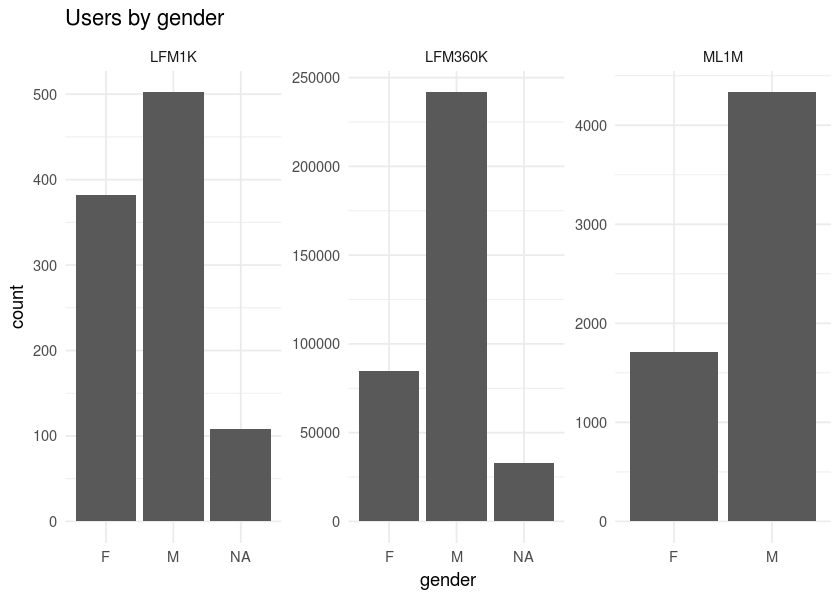

In [39]:
ggplot(all_user_stats) +
    aes(x=gender) +
    geom_bar() +
    facet_wrap(~ DataSet, scales="free") +
    ggtitle("Users by gender") +
    theme_minimal()

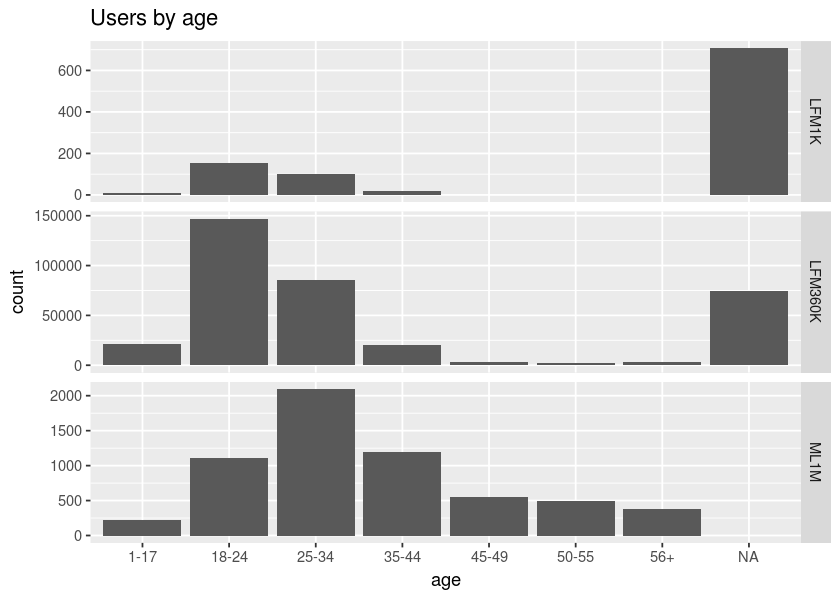

In [40]:
ggplot(all_user_stats) +
    aes(x=age) +
    geom_bar() +
    facet_grid(DataSet ~ ., scales="free_y") +
    ggtitle("Users by age")

## Per-demographic rating statistics

Do different groups consume different numbers of items, on average?

### Gender

In [41]:
gender.stats = all_user_stats %>%
    group_by(DataSet, gender) %>%
    summarize(NUsers=n(),
              MeanItemCount=mean(ItemCount),
              ICErr=sd(ItemCount) / sqrt(n()),
              MedItemCount=median(ItemCount))
gender.stats

DataSet,gender,NUsers,MeanItemCount,ICErr,MedItemCount
LFM1K,F,382,743.49215,35.09773842,562.5
LFM1K,M,502,1010.90239,47.85992580,655.5
LFM1K,NA,108,1047.57407,104.72926676,738.5
LFM360K,F,84930,48.20227,0.02758414,48.0
LFM360K,M,241642,49.14493,0.01739652,49.0
LFM360K,NA,32775,48.51698,0.05180196,49.0
ML1M,F,1709,144.20129,4.08830763,77.0
ML1M,M,4331,174.04041,3.05022666,102.0


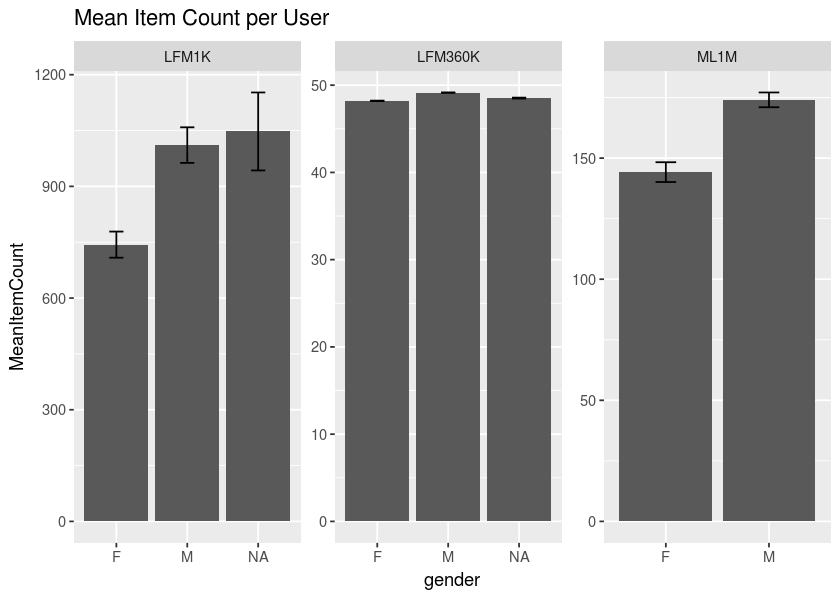

In [42]:
ggplot(gender.stats) +
    aes(x=gender, y=MeanItemCount,
        ymin=MeanItemCount-ICErr,
        ymax=MeanItemCount+ICErr) +
    geom_bar(stat="identity") + geom_errorbar(width=0.2) +
    facet_wrap(~ DataSet, scales="free") +
    ggtitle("Mean Item Count per User")

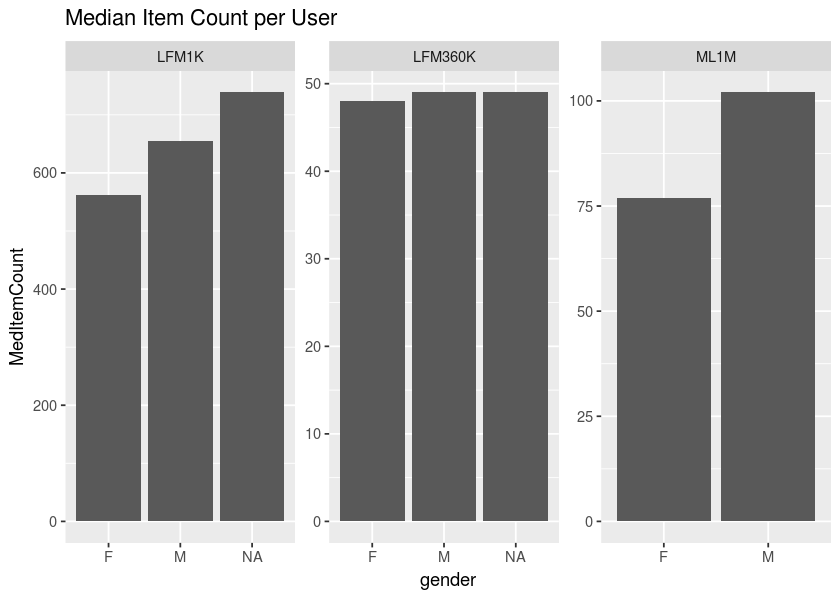

In [43]:
ggplot(gender.stats) +
    aes(x=gender, y=MedItemCount) +
    geom_bar(stat="identity") +
    facet_wrap(~ DataSet, scales="free") +
    ggtitle("Median Item Count per User")

Do different genders use higher or lower ratings?

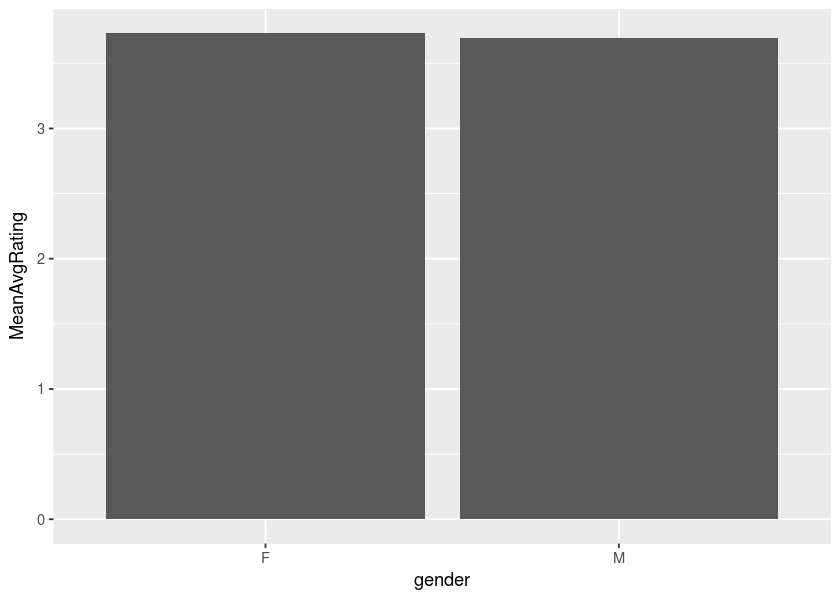

In [44]:
ggplot(ml_user_stats %>% group_by(gender) %>% summarize(MeanAvgRating=mean(MeanRating))) +
    aes(x=gender, y=MeanAvgRating) +
    geom_bar(stat="identity")

Now, let's examine popularity preference.

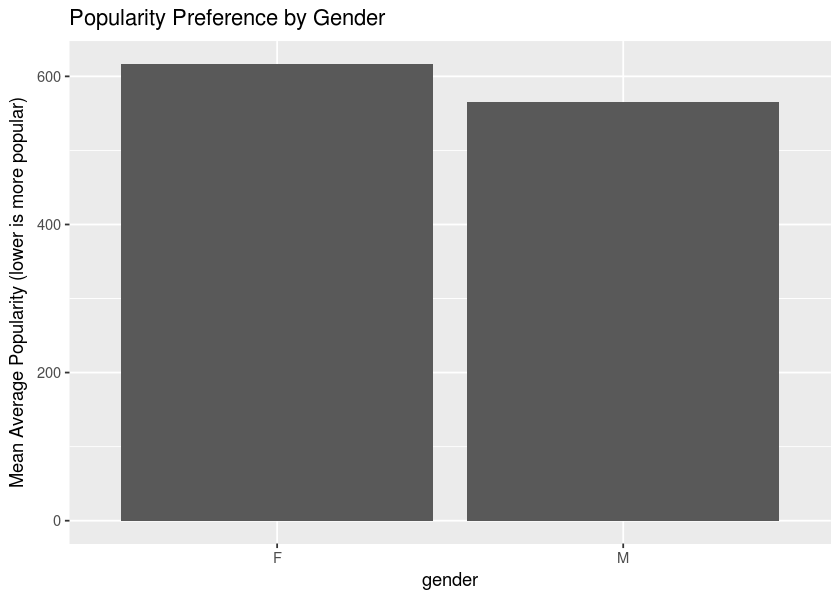

In [45]:
ggplot(ml_user_stats %>% group_by(gender) %>% summarize(MeanPop=mean(MeanPopRank))) +
    aes(x=gender, y=MeanPop) +
    geom_bar(stat="identity") +
    ylab("Mean Average Popularity (lower is more popular)") +
    ggtitle("Popularity Preference by Gender")

Male users - of which there are considerably more - tend to rate more popular movies. This is expected - the dominant group's movies will, by nature, be more popular - but it does document that demographics and popularity will confound.

### Age

In [46]:
age.stats = all_user_stats %>%
    group_by(DataSet, age) %>%
    summarize(NUsers=n(),
              MeanItemCount=mean(ItemCount),
              ICErr=sd(ItemCount) / sqrt(n()),
              MedItemCount=median(ItemCount))
age.stats

DataSet,age,NUsers,MeanItemCount,ICErr,MedItemCount
LFM1K,1-17,9,608.4444,186.80286,458.0
LFM1K,18-24,153,691.2614,47.49958,506.0
LFM1K,25-34,101,972.6931,83.63219,760.0
LFM1K,35-44,18,1576.0000,343.47661,1019.5
LFM1K,45-49,2,690.0000,591.00000,690.0
⋮,⋮,⋮,⋮,⋮,⋮
ML1M,25-34,2096,188.7195,4.549564,110
ML1M,35-44,1193,166.8089,5.748490,94
ML1M,45-49,550,152.0600,8.180004,81
ML1M,50-55,496,146.1492,8.069795,88


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

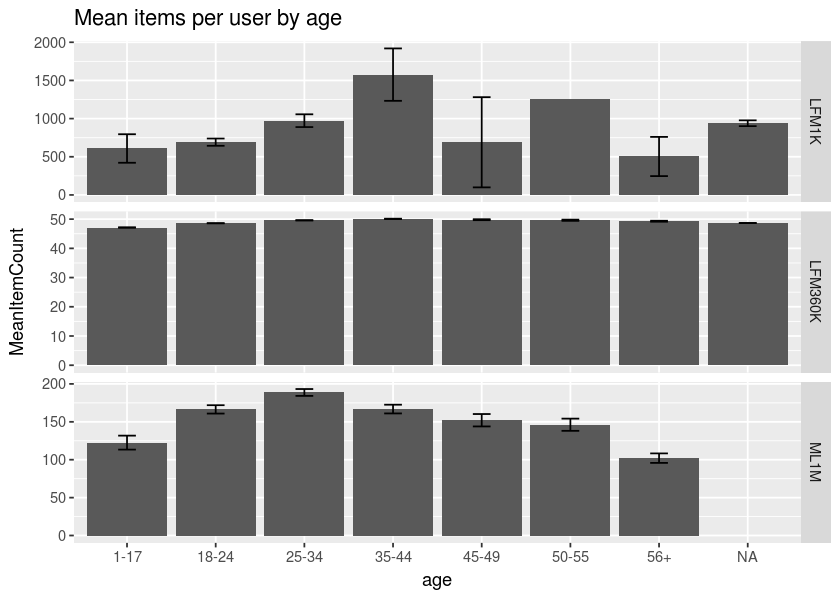

In [47]:
ggplot(age.stats) +
    aes(x=age, y=MeanItemCount, 
        ymin=MeanItemCount - ICErr,
        ymax=MeanItemCount + ICErr) +
    geom_bar(stat="identity") + geom_errorbar(width=0.2) +
    facet_grid(DataSet ~ ., scales="free_y") +
    ggtitle("Mean items per user by age")

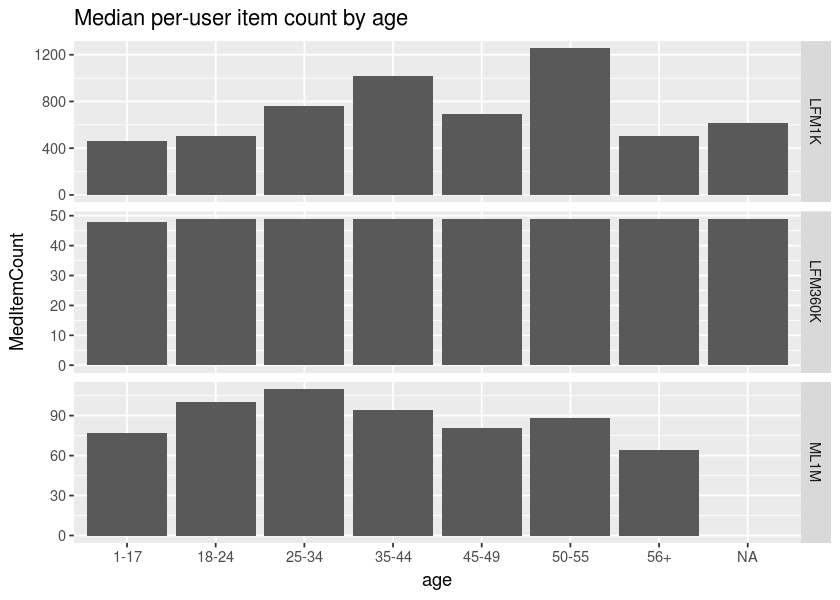

In [48]:
ggplot(age.stats) +
    aes(x=age, y=MedItemCount) +
    geom_bar(stat="identity") +
    facet_grid(DataSet ~ ., scales="free_y") +
    ggtitle("Median per-user item count by age")

## Integrated Plots

Now that we have explored, let's generate some integrated plots for the paper.

Start by computing demographics in tables we can stack together appropriately.

In [49]:
gender_stats = all_user_stats %>%
    group_by(DataSet, gender) %>%
    summarize(UserCount=n(), MedItems=median(ItemCount)) %>%
    rename(demoV=gender)
age_stats = all_user_stats %>%
    group_by(DataSet, age) %>%
    summarize(UserCount=n(), MedItems=median(ItemCount)) %>%
    rename(demoV=age)
demo_stats =
    bind_rows(Gender=gender_stats, Age=age_stats, .id="Demographic") %>%
    group_by(Demographic, DataSet) %>%
    mutate(UserFrac = UserCount / sum(UserCount))
demo_stats

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”

Demographic,DataSet,demoV,UserCount,MedItems,UserFrac
Gender,LFM1K,F,382,562.5,0.3850806
Gender,LFM1K,M,502,655.5,0.5060484
Gender,LFM1K,NA,108,738.5,0.1088710
Gender,LFM360K,F,84930,48.0,0.2363454
Gender,LFM360K,M,241642,49.0,0.6724475
⋮,⋮,⋮,⋮,⋮,⋮
Age,ML1M,25-34,2096,110,0.34701987
Age,ML1M,35-44,1193,94,0.19751656
Age,ML1M,45-49,550,81,0.09105960
Age,ML1M,50-55,496,88,0.08211921


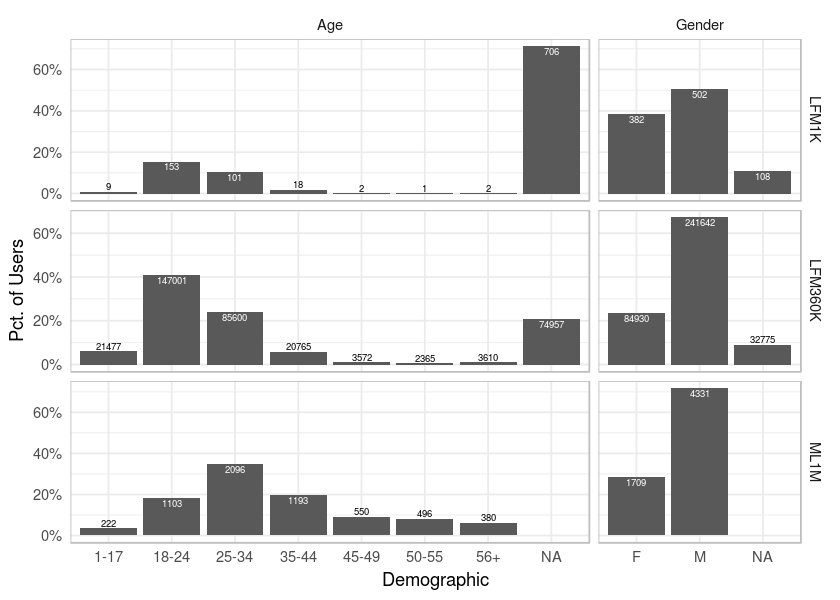

In [59]:
make.plot("users-by-demographic", width=5.5, height=3.5, {
    ggplot(demo_stats) +
        aes(x=demoV, y=UserFrac) +
        geom_bar(stat="identity") +
        geom_text(mapping=aes(label=UserCount, 
                              vjust=ifelse(UserFrac > 0.1, 1.25, -0.2),
                              color=ifelse(UserFrac > 0.1, "white", "black")),
                  size=2) +
        scale_color_identity() +
        scale_y_continuous(labels=scales::percent) +
        facet_grid(DataSet ~ Demographic, scales="free", space="free_x") +
        xlab("Demographic") +
        ylab("Pct. of Users") +
        theme_paper()
})

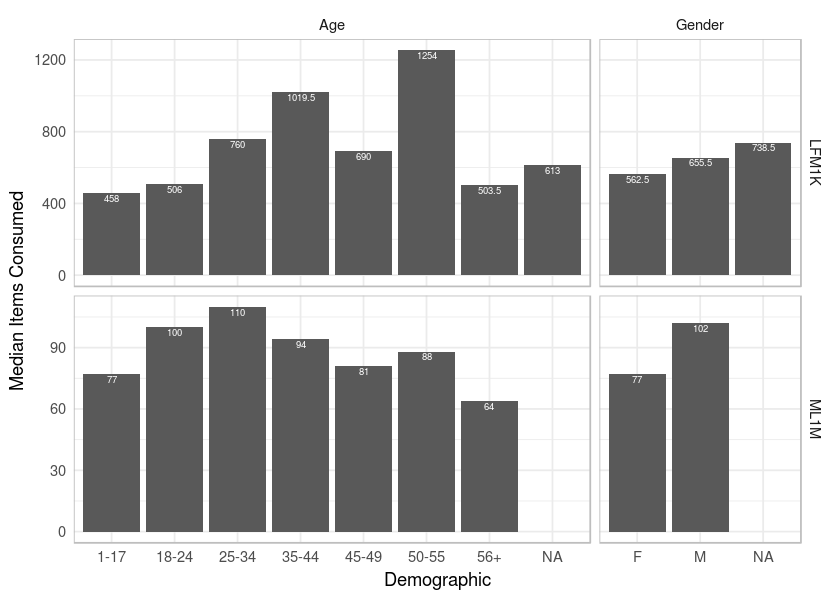

In [60]:
make.plot("ratings-by-demographic", width=5.5, height=2.5, {
    ggplot(demo_stats %>% filter(DataSet != "LFM360K")) +
        aes(x=demoV, y=MedItems) +
        geom_bar(stat="identity") +
        geom_text(mapping=aes(label=MedItems),
                  size=2, color="white", vjust=1.25) +
        facet_grid(DataSet ~ Demographic, scales="free", space="free_x") +
        xlab("Demographic") +
        ylab("Median Items Consumed") +
        theme_paper()
})